# Development of a Customer Churn Prediction Model

### Description
The telecommunications operator wants to learn how to predict customer churn. If it is determined that a user plans to leave, they will be offered promotional codes and special conditions. The operator's team has collected personal data about some customers, as well as information about their tariffs and contracts.

The cost of marketing expenses to regain a lost customer is quite high; it is cheaper to retain the customer. Therefore, the company's management has assigned the task of developing a customer churn prediction model.

### Objective

The objective of my project is to develop a customer churn prediction model using binary classification task, available data, and supervised learning methods. I need to achieve an AUC-ROC metric value of at least 0.85 on the test dataset.

### Data Description

The data consists of files obtained from various sources:

- `contract_new.csv` - contract information
- `personal_new.csv` - customer personal data
- `internet_new.csv` - information about internet services
- `phone_new.csv` - information about phone services

In all files, the `customerID` column contains the customer code.

The contract information is up-to-date as of February 1, 2020.

### Service Description

The operator provides two main types of services:

1. Landline telephone communication. It is possible to connect a telephone device to multiple lines simultaneously.
2. Internet. The connection can be of two types: through a telephone line (DSL - digital subscriber line) or through fiber optic cable (Fiber optic).

Additionally, the following services are available:

- Internet security: antivirus (DeviceProtection) and blocking of unsafe websites (OnlineSecurity).
- Dedicated technical support line (TechSupport).
- Cloud storage for data backup (OnlineBackup).
- Streaming television (StreamingTV) and a movie catalog (StreamingMovies).

Customers can pay for the services on a monthly basis or enter into a contract for 1-2 years. Various payment methods are available, and customers have the option to receive an electronic receipt.

## Data Loading

In [1]:
# Uncomment
#!pip -q install phik
#!pip install scikit-learn==1.2.2
#!pip install lightgbm

In [2]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn

import phik
from phik.report import plot_correlation_matrix
from phik import report


from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    roc_curve,
    classification_report
)


from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

In [4]:
# Defining Constants
RANDOM_STATE = 20623

In [5]:
# Loading Datasets
try:
    df_contract = pd.read_csv("/datasets/contract_new.csv")
    df_personal = pd.read_csv("/datasets/personal_new.csv")
    df_internet = pd.read_csv("/datasets/internet_new.csv")
    df_phone = pd.read_csv("/datasets/phone_new.csv")

except:
    df_contract = pd.read_csv("datasets/contract_new.csv")
    df_personal = pd.read_csv("datasets/personal_new.csv")
    df_internet = pd.read_csv("datasets/internet_new.csv")
    df_phone = pd.read_csv("datasets/phone_new.csv")

# Вывод размеров наборов данных
print(f"Dataset Size contract: {df_contract.shape}")
print(f"Dataset Size personal: {df_personal.shape}")
print(f"Dataset Size internet: {df_internet.shape}")
print(f"Dataset Size phone: {df_phone.shape}")

Dataset Size contract: (7043, 8)
Dataset Size personal: (7043, 5)
Dataset Size internet: (5517, 8)
Dataset Size phone: (6361, 2)


## Preliminary Exploratory Data Analysis (EDA)

* I plan to conduct a preliminary analysis of the raw datasets.
- [x] Explore the objects and features in the datasets.
- [x] Explore the data types.
- [x] Explore duplicates in the data.
- [x] Explore missing values in the data.
- [x] Explore the number of unique values for categorical features.

### Contract Information

In [6]:
# Printing the first few rows of the dataset
df_contract.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17


In [7]:
# Checking duplicates based on customerID
duplicates = df_contract.duplicated(subset=["customerID"])
print(f"Number of customerID duplicates: {duplicates.sum()}")

Number of customerID duplicates: 0


In [8]:
def is_empty(df):
    nan_ = df.isna().sum().sum()
    print(f"Number of Nan: {nan_}")
    em_ = (df == "").sum().sum()
    print(f'Number of empty str: (""): {em_}')
    sp_ = (df == " ").sum().sum()
    print(f'Number of spaces:(" "): {sp_}')
    if sp_ > 0:
        print(f'{df.columns[df.apply(lambda col: np.any(col == " "))]}')

In [9]:
# Check thr Nan and empy str
is_empty(df_contract)

Number of Nan: 0
Number of empty str: (""): 0
Number of spaces:(" "): 11
Index(['TotalCharges'], dtype='object')


* Let's take a closer look at the number of unique values in the `EndDate` column, as it is currently the most likely candidate to be the target feature.

In [10]:
# Number of unique values
df_contract.EndDate.value_counts()

No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2014-09-01       2
2014-12-01       2
2014-06-01       1
2014-10-01       1
2014-11-01       1
Name: EndDate, Length: 67, dtype: int64

* Based on the obtained information, I conclude that in the EndDate column, the "No" values correspond to the negative class (active contract), while the values with a date correspond to the positive class (terminated contract/customer churned to another company).

In [11]:
# Calculate the class ratio.
class_ratio = (
    df_contract.query('EndDate == "No"')["EndDate"].count() / df_contract.shape[0]
)
print(f"Class ratio: {class_ratio:.2f}")

Class ratio: 0.84


In [12]:
# Dataset Information
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


From the feature information, it is evident that `MonthlyCharges` and `TotalCharges` contain quantitative data. However, `TotalCharges` has an `object` data type and contains spaces. Let's filter the table to include only non-numeric values.

In [13]:
# Create a mask for non-numeric values in the 'TotalCharges' column
non_numeric_mask = pd.to_numeric(df_contract["TotalCharges"], errors="coerce").isna()

filtered_df = df_contract[non_numeric_mask]
filtered_df

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


In [14]:
# Examine the TotalCharges data for the previous month
df_contract[
    (df_contract["BeginDate"] == "2020-01-01") & (df_contract["Type"] == "Two year")
].head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
2828,8559-WNQZS,2020-01-01,No,Two year,No,Mailed check,20.45,20.45
5987,1099-GODLO,2020-01-01,No,Two year,No,Mailed check,20.35,20.76


* Spaces/missing values in the `TotalCharges` column are only present for customers who signed contracts on 2020-02-01. Let's test this hypothesis.

In [15]:
# Filter only the customers who signed contracts on 2020-02-01
new_customer = df_contract.query('BeginDate == "2020-02-01"')
print(
    f"Spaces in the TotalCharges feature are only present for new customers: {filtered_df.equals(new_customer)}"
)

Spaces in the TotalCharges feature are only present for new customers: True


* I have made the decision to convert the values in the `TotalCharges` column and fill in the missing values with zero after the conversion. This is because the total charges for these new customers are presumed to be zero or close to zero, based on the data for January 2020.
* Let's first display three rows from the datasets with missing values and without missing values, and then after replacing the missing values, we will verify these rows.

In [16]:
# Examples without spaces
df_contract.sample(3, random_state=RANDOM_STATE)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
2674,1855-CFULU,2019-10-01,No,Month-to-month,No,Mailed check,20.05,85.81
4449,2001-EWBQU,2015-02-01,No,Two year,No,Electronic check,104.70,6533.28
5145,3727-OVPRY,2014-08-01,2016-09-01,One year,Yes,Credit card (automatic),25.70,642.5


In [17]:
# Examples with spaces
filtered_df.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,


In [18]:
# Change the data type of the column to float
# If ‘coerce’, then invalid parsing will be set as NaN.
print(f"Dataset size before conversion: {df_contract.shape}")
df_contract.TotalCharges = pd.to_numeric(
    df_contract.TotalCharges, errors="coerce"
).fillna(0.1)
print(f"Dataset size after conversion: {df_contract.shape}")
print(f"Data type after conversion: {df_contract.TotalCharges.dtype}")

Dataset size before conversion: (7043, 8)
Dataset size after conversion: (7043, 8)
Data type after conversion: float64


In [19]:
# Examples without spaces
df_contract.sample(3, random_state=RANDOM_STATE)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
2674,1855-CFULU,2019-10-01,No,Month-to-month,No,Mailed check,20.05,85.81
4449,2001-EWBQU,2015-02-01,No,Two year,No,Electronic check,104.70,6533.28
5145,3727-OVPRY,2014-08-01,2016-09-01,One year,Yes,Credit card (automatic),25.70,642.50


In [20]:
# Examples of objects with missing values after conversion:
df_contract.iloc[filtered_df.index.tolist()].head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,0.1
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,0.1
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,0.1


* Now, after the conversion, I can plot histograms to visualize the distribution of quantitative data from the `MonthlyCharges` and `TotalCharges` columns.

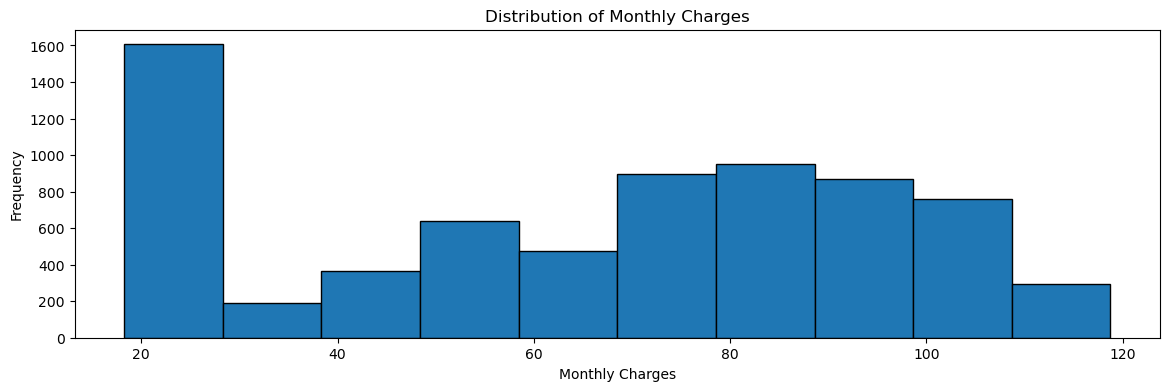

In [21]:
# Histogram of the distribution for MonthlyCharges
plt.figure(figsize=(14, 4))
plt.hist(df_contract["MonthlyCharges"], bins=10, edgecolor="black")
plt.xlabel("Monthly Charges")
plt.ylabel("Frequency")
plt.title("Distribution of Monthly Charges")

plt.show()

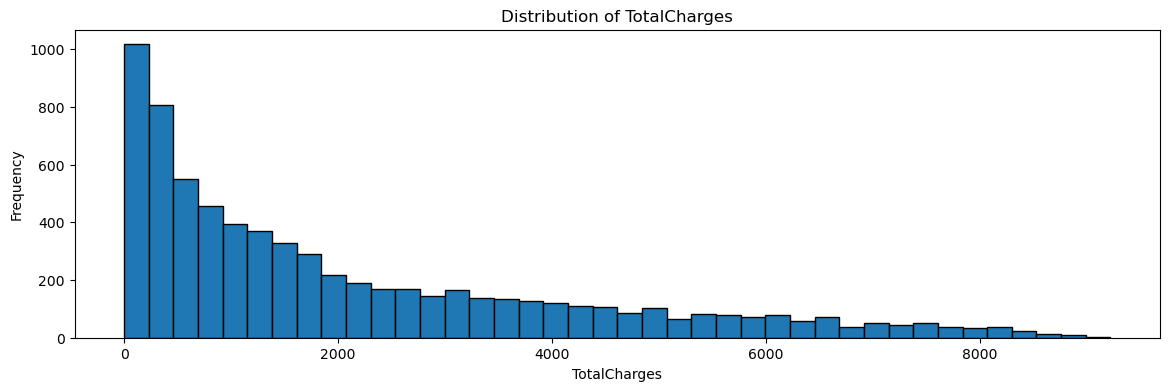

In [22]:
# Histogram of the distribution for TotalCharges
plt.figure(figsize=(14, 4))
plt.hist(df_contract["TotalCharges"], bins=40, edgecolor="black")
plt.xlabel("TotalCharges")
plt.ylabel("Frequency")
plt.title("Distribution of TotalCharges")

plt.show()

In [23]:
# Number of unique values
df_contract.nunique()

customerID          7043
BeginDate             77
EndDate               67
Type                   3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6658
dtype: int64

In [24]:
# The quantitative features
df_contract.describe()

,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000
mean,64.761692,2115.313041
std,30.090047,2112.742658
min,18.250000,0.100000
25%,35.500000,436.750000
50%,70.350000,1343.350000
75%,89.850000,3236.690000
max,118.750000,9221.380000


* We can observe that the quantitative features have different scales. In the project, we will be using a Logistic Regression model, which is sensitive to the scale of input features. Therefore, it will be necessary to perform feature normalization on these features.

### Customer's personal data

In [25]:
# Printing the first few rows of the dataset
df_personal.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No


In [26]:
# Checking for duplicates based on customerID
duplicates = df_personal.duplicated(subset=["customerID"])
print(f"Number of customerID duplicates: {duplicates.sum()}")

Number of customerID duplicates: 0


In [27]:
# Checking for missing values/spaces.
is_empty(df_personal)

Number of Nan: 0
Number of empty str: (""): 0
Number of spaces:(" "): 0


In [28]:
# Dataset information
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [29]:
# Number of unique values
df_personal.nunique()

customerID       7043
gender              2
SeniorCitizen       2
Partner             2
Dependents          2
dtype: int64

### Information about internet services

In [30]:
# Printing the first few rows of the dataset
df_internet.head(3)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No


In [31]:
# Checking for duplicates based on customerID
duplicates = df_internet.duplicated(subset=["customerID"])
print(f"Number of customerID duplicates: {duplicates.sum()}")

Number of customerID duplicates: 0


In [32]:
# Checking for missing values/spaces
is_empty(df_internet)

Number of Nan: 0
Number of empty str: (""): 0
Number of spaces:(" "): 0


In [33]:
# Dataset information
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [34]:
# Number of unique values
df_internet.nunique()

customerID          5517
InternetService        2
OnlineSecurity         2
OnlineBackup           2
DeviceProtection       2
TechSupport            2
StreamingTV            2
StreamingMovies        2
dtype: int64

### Information about phone services

In [35]:
# Printing the first few rows of the dataset
df_phone.head(3)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No


In [36]:
# Checking for duplicates based on customerID
duplicates = df_phone.duplicated(subset=["customerID"])
print(f"Number of customerID duplicates: {duplicates.sum()}")

Number of customerID duplicates: 0


In [37]:
# Checking for missing values/spaces
is_empty(df_phone)

Number of Nan: 0
Number of empty str: (""): 0
Number of spaces:(" "): 0


In [38]:
# Dataset information
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [39]:
# Number of unique values
df_phone.nunique()

customerID       6361
MultipleLines       2
dtype: int64

### Preliminary analysis findings

Below are the conclusions from the preliminary analysis of the raw data:

- The number of unique users (objects) is 7043.
- The target feature (contract termination status) is `EndDate` from the `contract_new.csv` dataset.
   - There is a class imbalance, with 16% representing the positive class (contract terminated by the customer).
<br><br>   
- Sizes of the datasets:
   - Size of the `contract` dataset: (7043, 8)
   - Size of the `personal` dataset: (7043, 5)
   - Size of the `internet` dataset: (5517, 8)
   - Size of the `phone` dataset: (6361, 2)
<br><br>   
- Most of the features in the raw datasets are categorical.
   - Additional encoding will be required.
<br><br> 
- Quantitative features, such as `MonthlyCharges` and `TotalCharges` from the `contract_new.csv` dataset, will require normalization for logistic regression.

- In total, there are 18 features available for the objects.

- No missing values or duplicates were found in the raw data.

- The features `BeginDate` and `EndDate` in the `contract_new.csv` dataset are of type `object` but contain date information.
<br><br>
For further analysis, it is necessary to merge the raw datasets into one working dataset, using the unique customer identification number (`customerID`) as the key for merging.
<br><br>
* Things to address after merging the raw data:
- Change the feature names from CamelCase to snake_case.
- Adjust data types.
- Handle any resulting missing values.

**Preliminary Plan**
<br><br>
1. Further data analysis after merging:
   * Handling missing values/duplicates (if necessary)
   * Analysis of quantitative features
   * Analysis of categorical features
<br><br>
2. Data preprocessing:
   * Handling class imbalance (if necessary)
   * Splitting into train, validation, and test sets
   * Encoding and normalization
<br><br>
3. Model training and validation (Initially Logistic Regression and LightGBM):
   * Hyperparameter tuning
   * Validation analysis
   * Selection of the best model
<br><br>
4. Testing the final model:
   * Analysis of project results
<br><br>
5. Project report.
<br><br>
Please note that this is a preliminary work plan and further adjustments may be needed based on the specific requirements and findings during the project.

## EDA

### Merging the source datasets

In [40]:
# Merging the source datasets
merged_df = pd.merge(df_contract, df_personal, on="customerID", how="left")
merged_df = pd.merge(merged_df, df_internet, on="customerID", how="left")
merged_df = pd.merge(merged_df, df_phone, on="customerID", how="left")

print(f"Size of the merged dataset: {merged_df.shape}")

Size of the merged dataset: (7043, 20)


In [41]:
# Header of the df
merged_df.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No


### Data preprocessing

In [42]:
# Changing column/feature names to snake_case
merged_df.columns = [
    column_name[0].lower()
    + "".join(["_" + c.lower() if c.isupper() else c for c in column_name[1:]])
    for column_name in merged_df.columns
]
merged_df = merged_df.rename(
    columns={"customer_i_d": "customer_id", "streaming_t_v": "streaming_tv"}
)
merged_df.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines'],
      dtype='object')

In [43]:
# Check the Nan
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   float64
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support       5517 

#### Missing data handling


* When merging the original datasets, we encountered missing values in the features from the `df_internet` and `df_phone` tables. This was expected since these tables contained fewer objects/clients than the `df_contract` and `df_personal` tables.
* It is worth noting that the `df_internet` and `df_phone` tables contain information about separate sets of services, namely "Internet" and "Phone" services, respectively. Not all clients may have subscribed to both services; some may have chosen only one.
* Let's verify the assumption that the missing values in these two service blocks are not interrelated, meaning there are no objects that did not subscribe to any of the services.

In [44]:
print(
    f"The number of clients who did not subscribe to any of the service bundles is: \
    {merged_df.query('internet_service.isna() and multiple_lines.isna()').shape[0]}"
)

The number of clients who did not subscribe to any of the service bundles is:     0


* To determine a suitable value for the missing data, let's examine the values used when, for example, the `online_backup` service is not utilized by a customer who still uses the "Internet" service bundle. 
* But first, let's take a look at the unique values of the `internet_service` feature, which serves as an umbrella for all other features in the "Internet" service bundle.

In [45]:
# Examine the unique values of the internet_service feature:
merged_df.internet_service.unique()

array(['DSL', 'Fiber optic', nan], dtype=object)

In [46]:
# examine the unique values of the feature:
unique_values = (
    merged_df[
        [
            "online_security",
            "online_backup",
            "device_protection",
            "tech_support",
            "streaming_tv",
            "streaming_movies",
        ]
    ]
    .values.ravel()
    .tolist()
)
print(list(set(unique_values)))

['No', 'Yes', nan]



* The "umbrella" feature `internet_service` has unique values of 'DSL' and 'Fiber optic', representing different types of connections.
* The other features in the "Internet" service bundle have unique values of 'No' and 'Yes', indicating whether the service is connected or not.
<br><br>
Therefore, for the objects with missing data, we can use the existing value of 'No', which will indicate that the respective service is not connected for those objects.


In [47]:
# Filling the missing values with the value 'No'.
merged_df = merged_df.fillna("No")
print(f"Size merged_df: {merged_df.shape}")
print(f"Number of the Nan in merged_df: {merged_df.isna().sum().sum()}")

Size merged_df: (7043, 20)
Number of the Nan in merged_df: 0


#### Data Type Conversion

In [48]:
# Checks the dtypes
merged_df.dtypes

customer_id           object
begin_date            object
end_date              object
type                  object
paperless_billing     object
payment_method        object
monthly_charges      float64
total_charges        float64
gender                object
senior_citizen         int64
partner               object
dependents            object
internet_service      object
online_security       object
online_backup         object
device_protection     object
tech_support          object
streaming_tv          object
streaming_movies      object
multiple_lines        object
dtype: object

* Before converting data types, let's make a copy of the `end_date` column, which represents the encoded target feature. We will rename the copy to `target`.

In [49]:
# Copy values from `end_date` to `target`
merged_df["target"] = merged_df.end_date
print(f"Size of merged_df: {merged_df.shape}")

Size of merged_df: (7043, 21)


In [50]:
# Check
merged_df.query('end_date != "No"')[["end_date", "target"]].sample(5)

,end_date,target
629,2019-11-01,2019-11-01
5620,2017-04-01,2017-04-01
3694,2019-05-01,2019-05-01
165,2015-06-01,2015-06-01
3083,2017-04-01,2017-04-01


* We need to encode the values in the `target` column, where the positive class represents a contract termination date and the negative class represents an active contract or the value "No" in the `end_date` feature.

In [51]:
# Encode the target values
merged_df["target"] = merged_df["target"].replace("No", False)
merged_df["target"] = merged_df["target"] != False
merged_df["target"] = merged_df["target"].astype(int)
print(f"Size of merged_df: {merged_df.shape}")

Size of merged_df: (7043, 21)


In [52]:
# Checks
a_ = merged_df.query('end_date != "No"')[["end_date"]].index
b_ = merged_df.query("target == 1")[["target"]].index
print(f"Checking: {a_.equals(b_)}")

Checking: True


To change the values in the `end_date` column, we can perform the following steps:

1. Convert the `end_date` and `begin_date` columns to the DateTime data type.
2. Handle the values in the `end_date` column that are not valid dates by using the `errors='coerce'` argument. This will convert any invalid values to `NaT` (Not a Time) in the DateTime format.

By applying these steps, we can ensure that the `end_date` column contains valid date values and any invalid values are properly handled.

In [53]:
# Change dtype
merged_df["begin_date"] = pd.to_datetime(merged_df["begin_date"], errors="coerce")
merged_df["end_date"] = pd.to_datetime(merged_df["end_date"], errors="coerce")
print(f"Size of merged_df: {merged_df.shape}")

Size of merged_df: (7043, 21)


In [54]:
# Check the dtype
merged_df[["begin_date", "end_date"]].dtypes

begin_date    datetime64[ns]
end_date      datetime64[ns]
dtype: object

* The transformation has been applied correctly, and the values "No" have been changed to NaT. Since the end_date column will be used to generate a new feature and then removed, it won't affect the training process as it will no longer be considered as part of the target variable.

In [55]:
# Checking Nan/NaT
is_empty(merged_df)

Number of Nan: 5942
Number of empty str: (""): 0
Number of spaces:(" "): 0


In [56]:
# Count number of NaT values
print(f"The number of NaT values in the end_date: {merged_df.end_date.isna().sum()}")

The number of NaT values in the end_date: 5942


* The remaining missing values in the end_date column will be handled during the feature engineering stage.

### Feature Analysis

After merging the tables and preprocessing the data, it is necessary to analyze the available features. This will help in selecting the appropriate methods for feature encoding, scaling, and generating new features.

In [57]:
# Show info
dt_ = merged_df.dtypes.to_frame().rename(columns={0: "dtype"})
nu_ = merged_df.nunique().to_frame().rename(columns={0: "nunique"})
sam_ = merged_df.sample(random_state=RANDOM_STATE).T.rename(columns={2674: "sample"})
m_info = dt_.merge(nu_, left_index=True, right_index=True, how="left")
m_info = m_info.merge(sam_, left_index=True, right_index=True, how="left")
m_info

,dtype,nunique,sample
customer_id,object,7043,1855-CFULU
begin_date,datetime64[ns],77,2019-10-01 00:00:00
end_date,datetime64[ns],66,NaT
type,object,3,Month-to-month
paperless_billing,object,2,No
payment_method,object,4,Mailed check
monthly_charges,float64,1585,20.05
total_charges,float64,6658,85.81
gender,object,2,Female
senior_citizen,int64,2,1


#### DateTime Features


First, let's take another look at the features with DateTime data type.

* `begin_date` - the date when the services started being used.
* `end_date` - the date when the services were terminated.
<br><br>
*The information about the contracts is up to date as of February 1, 2020.*

In [58]:
# Analysis of begin_date
print(
    f"Initial Date of Service Usage: {merged_df.begin_date.min().date()}"
)
print(
    f"Last Date of Service Usage: {merged_df.begin_date.max().date()}"
)

Initial Date of Service Usage: 2013-10-01
Last Date of Service Usage: 2020-02-01


In [59]:
# Analysis of end_date
print(
    f"Initial Date of Service Usage: {merged_df.end_date.min().date()}"
)
print(
    f"Last Date of Service Usage: {merged_df.end_date.max().date()}"
)

Initial Date of Service Usage: 2014-06-01
Last Date of Service Usage: 2020-01-01


In [60]:
# DataFrame with the count of new and churned customers per month
begin_date = (merged_df.groupby("begin_date")["customer_id"].count()).to_frame(
    name="new_customer"
)
end_date = (merged_df.groupby("end_date")["customer_id"].count()).to_frame(
    name="lost_customer"
)
merged_days = begin_date.merge(end_date, how="left", left_index=True, right_index=True)
merged_days.head(10)

,new_customer,lost_customer
begin_date,,
2013-10-01,3,NaN
2013-11-01,2,NaN
2013-12-01,3,NaN
2014-01-01,7,NaN
2014-02-01,366,NaN
2014-03-01,178,NaN
2014-04-01,114,NaN
2014-05-01,98,NaN
2014-06-01,97,1.0


In [61]:
# Tail of df
merged_days.tail(10)

,new_customer,lost_customer
begin_date,,
2019-05-01,123,23.0
2019-06-01,141,28.0
2019-07-01,156,25.0
2019-08-01,146,23.0
2019-09-01,237,32.0
2019-10-01,237,31.0
2019-11-01,237,30.0
2019-12-01,220,38.0
2020-01-01,233,39.0


In [62]:
# Check the data type of the index and the presence of any missing dates
print(merged_days.index.dtype == "datetime64[ns]")
print(merged_days.index.is_monotonic_increasing)

True
True


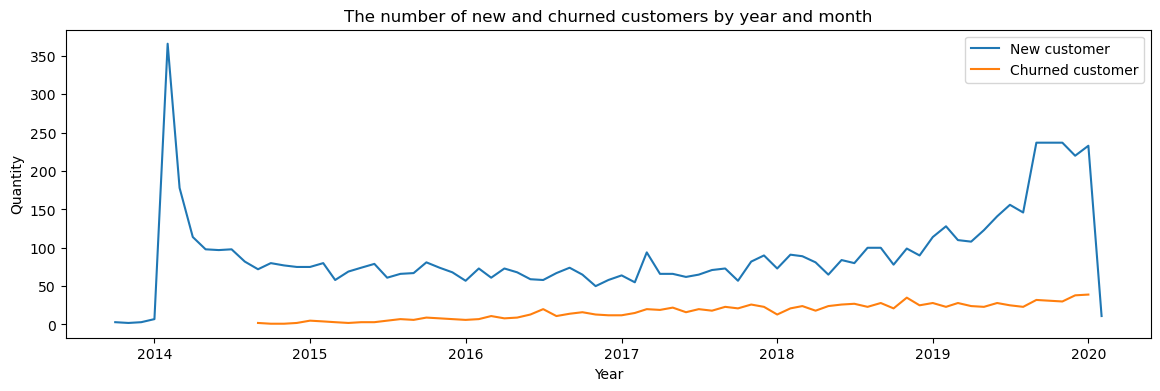

In [63]:
# Plot a graph showing the number of new and churned customers
plt.figure(figsize=(14, 4))
plt.plot(merged_days["new_customer"], label="New customer")
plt.plot(merged_days["lost_customer"], label="Churned customer")
plt.xlabel("Year")
plt.ylabel("Quantity")
plt.title("The number of new and churned customers by year and month")
plt.legend()
plt.show()

* From the above graph, it can be observed that the number of new customers in the time series has some anomalies.
   * There is a sharp spike in the number of new customers at the beginning of 2014 (2014-02-01) followed by a gradual decline to average values.
   * There is a significant growth in 2019, reaching a plateau in September 2019, with relatively stable values until January 2020.
   * There is a steep drop in the number of new customers in February 2020, which is likely due to incomplete data for February 2020.
<br><br>
* As for the number of churned customers, they are absent until mid-2014. From mid-2014 to the beginning of 2020, the number of churned customers gradually increases.

In [115]:
# Cumulative Totals
merged_days["cumulative_new"] = merged_days["new_customer"].cumsum()
merged_days["cumulative_churn"] = merged_days["lost_customer"].cumsum()
merged_days["cumulative_total"] = (
    merged_days["cumulative_new"] - merged_days["cumulative_churn"]
)

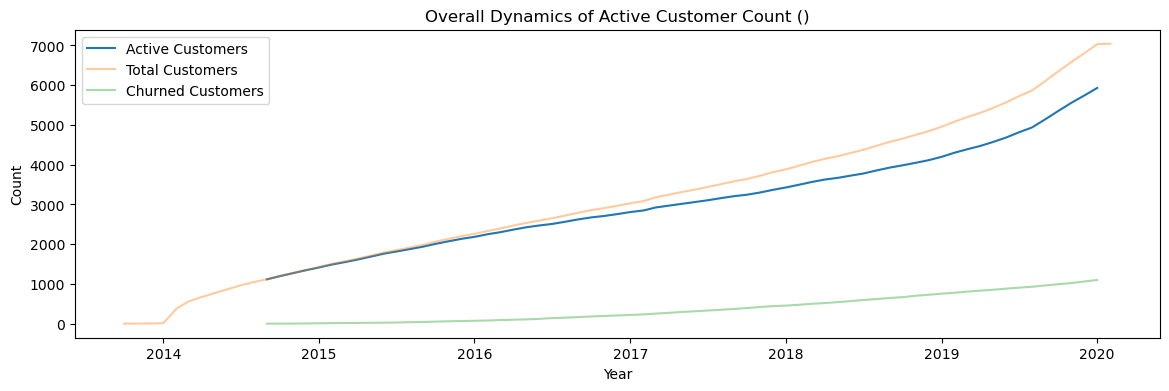

In [116]:
# Add cumulative totals for new and churned customers
plt.figure(figsize=(14, 4))
plt.plot(merged_days["cumulative_total"], label="Active Customers", alpha=1)
plt.plot(merged_days["cumulative_new"], label="Total Customers", alpha=0.4)
plt.plot(merged_days["cumulative_churn"], label="Churned Customers", alpha=0.4)
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Overall Dynamics of Active Customer Count ()")
plt.legend()
plt.show()

* On this graph, it can be noticed that the number of customers terminating their contracts is gradually increasing without significant fluctuations.
* However, the total number of customers and the number of active customers have been increasing in recent months. This could be attributed to marketing activities or the introduction of new services.
<br><br>
* Returning to the analysis of the original features, it's worth noting that the DateTime type is useful because it allows us to generate new features, such as extracting the year or month. With two features containing dates, we can calculate the number of months between the contract start date and end date, or for active customers, we can use the last available date from the dataset to determine how long the customer has been using the company's services.
<br><br>
In the next part of the project, I plan to generate new features from the DateTime features.

#### Categorical Features

Analyzing these categorical features will help us understand the distribution and patterns within each category, which can be useful for feature encoding and modeling techniques in the next steps of the project.

In [66]:
# Print info
m_info

,dtype,nunique,sample
customer_id,object,7043,1855-CFULU
begin_date,datetime64[ns],77,2019-10-01 00:00:00
end_date,datetime64[ns],66,NaT
type,object,3,Month-to-month
paperless_billing,object,2,No
payment_method,object,4,Mailed check
monthly_charges,float64,1585,20.05
total_charges,float64,6658,85.81
gender,object,2,Female
senior_citizen,int64,2,1


* It can be observed that categorical features, except for `senior_citizen`, have the object data type.
<br><br>
* We also have two groups of categorical features:
    * "Binary" - *two unique values*:
        * `paperless_billing`, `gender`, `senior_citizen`, `partner`, `dependents`, `online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_tv`, `streaming_movies`, `multiple_lines`
        * All these features can be represented as `False` and `True` (0/1, yes/no, Female/Male, etc.)
<br><br>
    * "Categorical" - *more than two unique values*:
        * `contract_type`, `payment_method`, `internet_service`

<br>                
For linear models, it will be necessary to encode the categorical feature values into numerical values, resulting in `0` and `1` as output. For this type of model, I will use the **One-Hot Encoding** method.
<br><br>
For decision tree models, it will also be necessary to encode the categorical feature values into numerical values. For this type of model, I will use the **Ordinal Encoding** method.
<br><br>
For gradient boosting models, there is no need to perform preliminary encoding of categorical features. The encoding is done automatically. We only need to specify the `categorical_feature` parameter value in the `fit()` method.
<br><br>
Transformers for each type of model will be incorporated into the pipeline.

#### Quantitative features

In our merged table, we have two quantitative features: `monthly_charges` and `total_charges`. As mentioned earlier in the *Preliminary EDA - Contract Information* section, these features have different scales and should be normalized.

Let's examine any outliers and the distribution of values for these features.

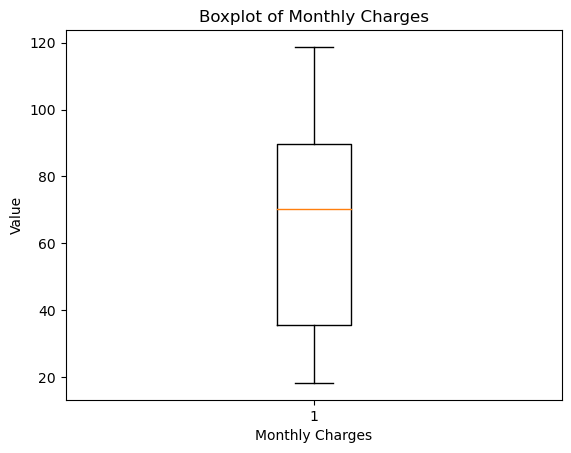

In [67]:
# Plot a boxplot for the feature monthly_charges
plt.boxplot(merged_df["monthly_charges"])
plt.title("Boxplot of Monthly Charges")
plt.xlabel("Monthly Charges")
plt.ylabel("Value")

plt.show()

For this feature, I plan to apply Min-Max normalization. The resulting values after transformation will be scaled within the range of 0 to 1. Since there are no outliers in the values, this normalization method is suitable for us.

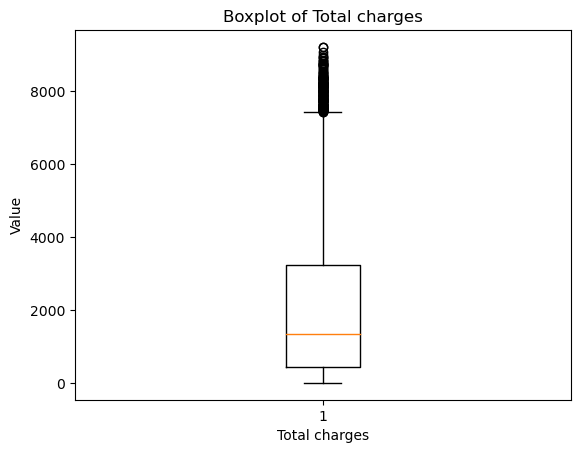

In [68]:
# Plot a boxplot for the feature monthly_charges
plt.boxplot(merged_df["total_charges"])
plt.title("Boxplot of Total charges")
plt.xlabel("Total charges")
plt.ylabel("Value")

plt.show()

Based on the earlier analysis of missing values in the `total_charges` feature, we can make an assumption that the value of `total_charges` is calculated from the value of `monthly_charges` multiplied by the number of months the customer has been active.

Let's see if there is such a correlation during the collinearity check. However, for the normalization of values in this feature, I plan to use the MinMax transformer.

* In the combined dataset, there are only two features left without analysis - `customer_id` and `target`.
   * `customer_id` - a unique identification number of the customer/contract - it is not needed for our project.
   * `target` - this is our target feature.

## Feature engeniring

* In this section of the project, I plan to generate new features from the existing ones: `begin_date` and `end_date`.

   * Year of customer registration
   * Month of customer registration
   * Number of months since customer registration (for active customers, the number of months until 2020-02-01)
   * Customer's total charges over the entire active period / compare with data from `total_charges`.

In [69]:
# Fill NaT
merged_df.end_date = pd.to_datetime(merged_df.end_date.fillna("2020-02-01"))
print(f"Number of NaT: {merged_df.end_date.isna().sum()}")
print(f"Dtypes: {merged_df.end_date.dtypes}")

Number of NaT: 0
Dtypes: datetime64[ns]


In [70]:
# Create new features
print(f"Size of the df before: {merged_df.shape}")
merged_df["year"] = merged_df.begin_date.dt.year
merged_df["month"] = merged_df.begin_date.dt.month
merged_df["months"] = (merged_df.end_date - merged_df.begin_date) / np.timedelta64(
    1, "M"
)
merged_df["total_calc"] = merged_df.monthly_charges * merged_df.months
print(f"Size of the df after: {merged_df.shape}")

Size of the df before: (7043, 21)
Size of the df after: (7043, 25)


I plan to remove the columns `customer_id` as it does not contain useful information in its values, `end_date` as it has a direct relationship with the `target` variable, and `begin_date` as new features have already been generated based on it.

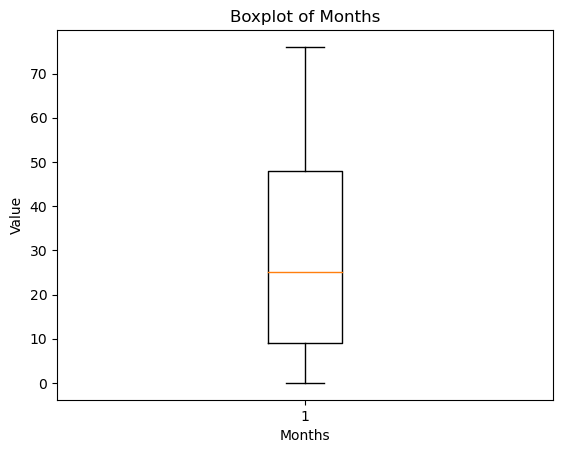

In [71]:
# Boxplot of months column
plt.boxplot(merged_df.months)
plt.title("Boxplot of Months")
plt.xlabel("Months")
plt.ylabel("Value")

plt.show()

In [72]:
# Drop the extra columns
print(f"Size before: {merged_df.shape}")
merged_df = merged_df.drop(columns=["customer_id", "end_date", "begin_date"])
print(f"Size after: {merged_df.shape}")

Size before: (7043, 25)
Size after: (7043, 22)


In [73]:
# Df info
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   gender             7043 non-null   object 
 6   senior_citizen     7043 non-null   int64  
 7   partner            7043 non-null   object 
 8   dependents         7043 non-null   object 
 9   internet_service   7043 non-null   object 
 10  online_security    7043 non-null   object 
 11  online_backup      7043 non-null   object 
 12  device_protection  7043 non-null   object 
 13  tech_support       7043 non-null   object 
 14  streaming_tv       7043 non-null   object 
 15  streaming_movies   7043 non-null   object 
 16  multiple_lines     7043 

## Checking for multicollinearity

To check for multicollinearity, I will use the `phik` library.
<br><br>
The phik package is a library that provides tools for computing the phi correlation coefficient, which measures the relationship between variables. It can be used to analyze the relationships between categorical and numerical variables in a dataset.
<br><br>
The `interval_cols` argument specifies which columns contain interval or continuous numerical data.

In [74]:
# Define interval_cols and compute the correlation matrix
interval_cols = ["monthly_charges", "total_calc", "total_charges", "months"]
phik_overview = merged_df.drop(columns=[]).phik_matrix(interval_cols=interval_cols)

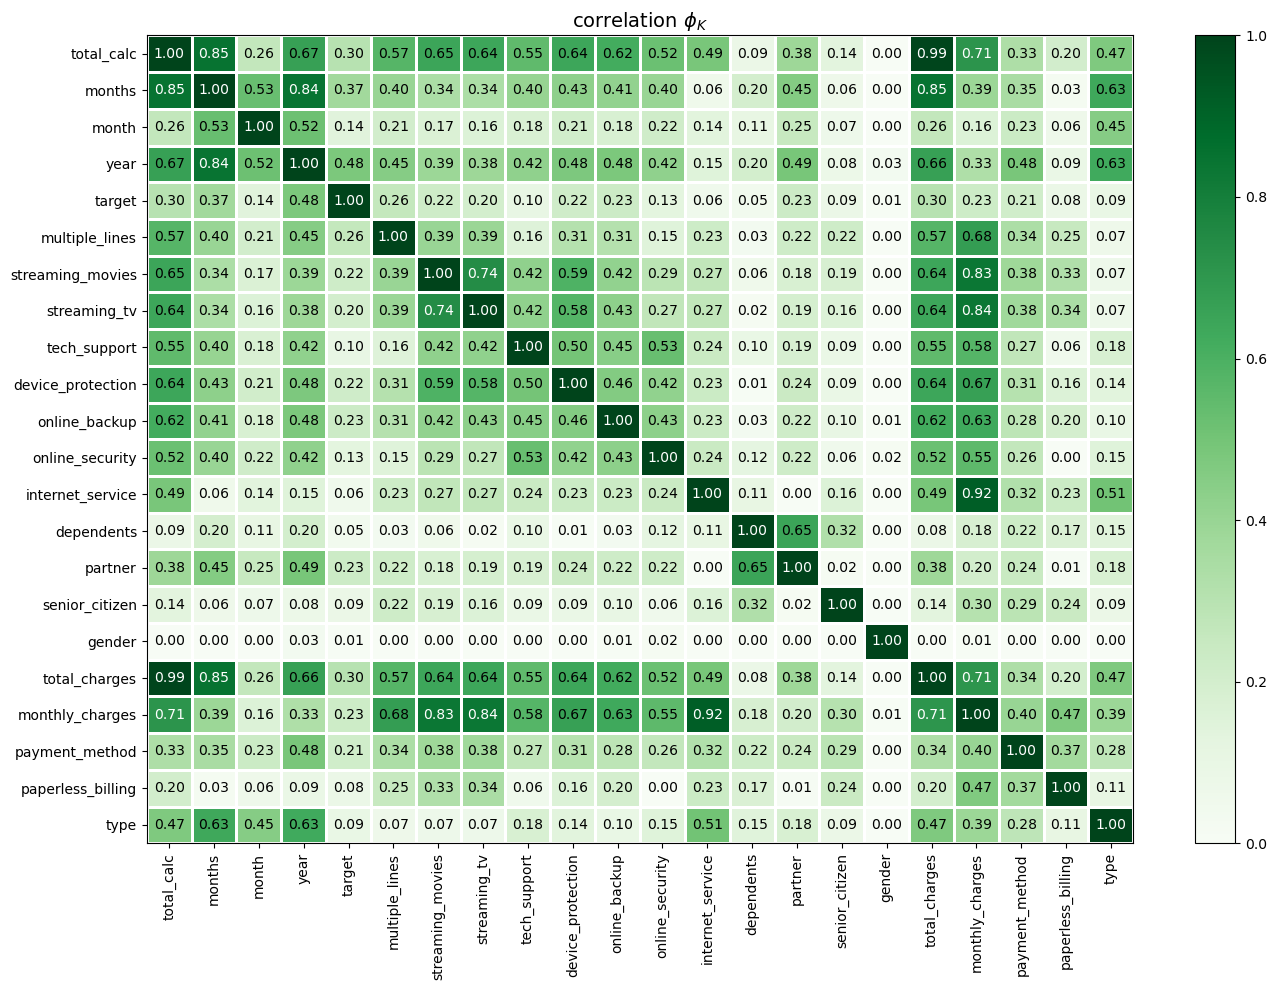

In [75]:
# Plot the correlation matrix
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0,
    vmax=1,
    color_map="Greens",
    title=r"correlation $\phi_K$",
    fontsize_factor=1,
    figsize=(14, 10),
)
plt.tight_layout()

* There is a strong correlation between `total_charges` and the generated feature `total_calc`. The generated feature duplicates an existing one and should be removed.
* The combination of the `total_charges` feature with the `year`/`months`/`month` features allows us to calculate the customers who have terminated their contracts. Therefore, this pair of features should be removed.

Let's also construct a Significance Matrix.
<br><br>
The Significance Matrix complements the correlation coefficient matrix by providing statistical information about the significance of each correlation. It shows the probability that the observed correlation coefficient is statistically significant and not due to chance.

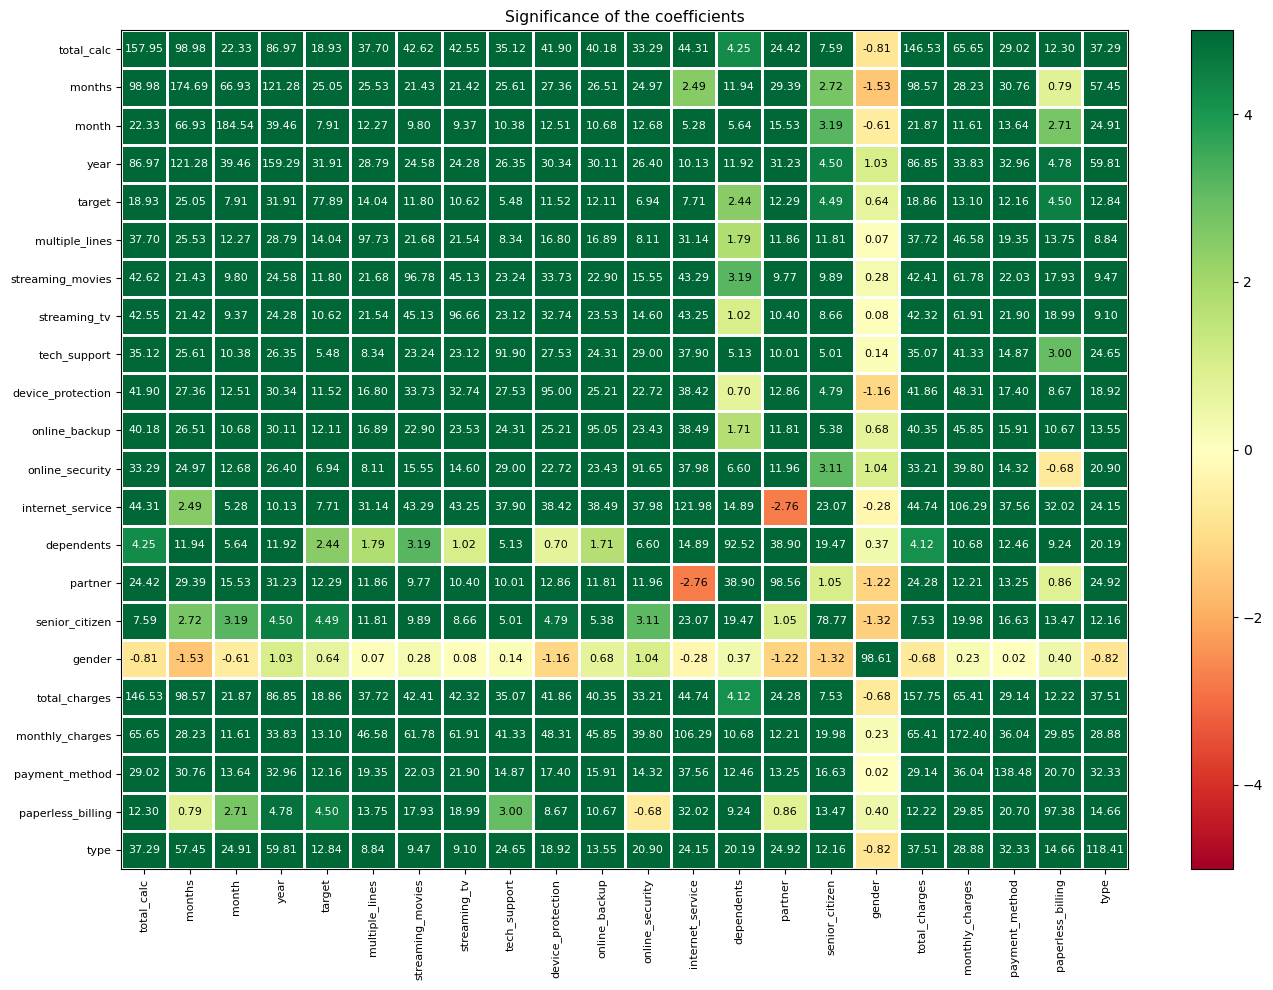

In [76]:
significance_overview = merged_df.significance_matrix(interval_cols=interval_cols)
plot_correlation_matrix(
    significance_overview.fillna(0).values,
    x_labels=significance_overview.columns,
    y_labels=significance_overview.index,
    vmin=-5,
    vmax=5,
    title="Significance of the coefficients",
    usetex=False,
    fontsize_factor=0.8,
    figsize=(14, 10),
)
plt.tight_layout()

The feature `gender` can be removed from the feature set, and the generated feature `total_calc`, as well as the features `total_charges`, `year`, and `month`, should be removed.

#### Deletion of features after verification

In [77]:
# Remove features
main_df = merged_df.drop(
    columns=["total_calc", "total_charges", "year", "month", "gender"]
)  # month 

print(f"Size of the existing df: {merged_df.shape}")
print(f"Size of the new df: {main_df.shape}")

Size of the existing df: (7043, 22)
Size of the new df: (7043, 17)


In [78]:
# DF info
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   senior_citizen     7043 non-null   int64  
 5   partner            7043 non-null   object 
 6   dependents         7043 non-null   object 
 7   internet_service   7043 non-null   object 
 8   online_security    7043 non-null   object 
 9   online_backup      7043 non-null   object 
 10  device_protection  7043 non-null   object 
 11  tech_support       7043 non-null   object 
 12  streaming_tv       7043 non-null   object 
 13  streaming_movies   7043 non-null   object 
 14  multiple_lines     7043 non-null   object 
 15  target             7043 non-null   int64  
 16  months             7043 

## Splitting the dataset

Split the resulting dataset into features and the target variable. Then we will proceed with splitting it into the training and testing subsets using a 75/25 ratio.

In [79]:
# Features and target
X = main_df.drop(columns=["target"])
y = main_df["target"]

print(f"Shape of X:{X.shape}")
print(f"Shape of y:{y.shape}")

Shape of X:(7043, 16)
Shape of y:(7043,)


In [80]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

print(f"Shape of X_train:{X_train.shape}")
print(f"Shape of X_test:{X_test.shape}")
print(f"Shape of y_train:{y_train.shape}")
print(f"Shape of y_test:{y_test.shape}")

Shape of X_train:(5282, 16)
Shape of X_test:(1761, 16)
Shape of y_train:(5282,)
Shape of y_test:(1761,)


After splitting the dataset into training and testing subsets, we have a sufficient size for training, cross-validation, and testing.
The next step will be to create a pipeline with transformers.

## Pipeline

I plan to test 3 models:
* Logistic Regression: `LogisticRegression()`
* Random Forest: `RandomForestClassifier()`
* Gradient Boosting Model: `LGBMClassifier()`

For linear models, it will be necessary to encode categorical features into numerical values, obtaining `0` and `1` as outputs. For this type of model, I will use the `OneHotEncoder()` transformer.

For decision tree-based models, it will also be necessary to encode categorical features into numerical values. For this type of model, I will use the `OrdinalEncoder()` transformer.

For gradient boosting models, there is no need to perform prior encoding of categorical features. The encoding process is done automatically, but it is necessary to specify the `categorical_feature` parameter in the `fit()` method. *I was unable to implement it - The pipeline was built for the random forest.*

For quantitative features like `months` and `monthly_charges`, I plan to apply the `MinMaxScaler()`. The transformed values will be in the range of 0 to 1. Since there are no outliers in the values, this normalization method is suitable for us.

Transformers for each type of model will be embedded in the pipeline.

In [81]:
# Define the parameters
ohe = OneHotEncoder(drop="first", handle_unknown="ignore")
oe = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=99)
min_max = MinMaxScaler()

lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
rf = RandomForestClassifier(min_samples_split=5, random_state=RANDOM_STATE)
lgbm = LGBMClassifier(random_state=RANDOM_STATE)

In [82]:
# Select categorical features for OneHotEncoder and OrdinalEncoder
cat_columns = [
    "type",
    "paperless_billing",
    "payment_method", 
    "senior_citizen",
    "partner",
    "dependents",
    "internet_service",
    "online_security",
    "online_backup",
    "device_protection",
    "tech_support",
    "streaming_tv",
    "streaming_movies",
    "multiple_lines"
]

# Select quantitative features for MinMaxScaler
num_columns = ["monthly_charges", "months"]  # 'total_charges', 'months'

In [83]:
# Create transformers for features
lr_preprocess = ColumnTransformer(
    transformers=[("num", min_max, num_columns), ("cat", ohe, cat_columns)]
)

rf_preprocess = ColumnTransformer(
    transformers=[("num", min_max, num_columns), ("cat", oe, cat_columns)]
)
lgbm_preprocess = ColumnTransformer(
    transformers=[("num", min_max, num_columns), ("cat", oe, cat_columns)]
)

In [84]:
# Set up the pipeline for the models
lr_pipe = make_pipeline(lr_preprocess, lr)
rf_pipe = make_pipeline(rf_preprocess, rf)
lgbm_pipe = make_pipeline(lgbm_preprocess, lgbm)

In [85]:
# Pipeline
lr_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['monthly_charges',
                                                   'months']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['type', 'paperless_billing',
                                                   'payment_method',
                                                   'senior_citizen', 'partner',
                                                   'dependents',
                                                   'internet_service',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                                                   'tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies',
                                                   'multiple_lines'])])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=20623))])

In [86]:
# Pipeline
rf_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['monthly_charges',
                                                   'months']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99),
                                                  ['type', 'paperless_billing',
                                                   'payment_method',
                                                   'senior_citizen', 'partner',
                                                   'dependents',
                                                   'internet_service',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                                                   'tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies',
                                                   'multiple_lines'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(min_samples_split=5,
                                        random_state=20623))])

In [87]:
# Pipeline
lgbm_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['monthly_charges',
                                                   'months']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99),
                                                  ['type', 'paperless_billing',
                                                   'payment_method',
                                                   'senior_citizen', 'partner',
                                                   'dependents',
                                                   'internet_service',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                                                   'tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies',
                                                   'multiple_lines'])])),
                ('lgbmclassifier', LGBMClassifier(random_state=20623))])

* The pipelines are set up. We can now proceed to training the models and evaluating their metrics using cross-validation.

## Training the models

We have prepared pipelines for each model type:

* Logistic Regression: `LogisticRegression()`
* Random Forest: `RandomForestClassifier()`
* Gradient Boosting: `LGBMClassifier()`

We will perform model testing with hyperparameter tuning using cross-validation. For each model, we will define a set of hyperparameters as a dictionary and pass it as an argument to the `GridSearchCV` function.

### Dummy Model

Using a Dummy model in classification tasks helps to get an initial understanding of the model's performance and assess how well it performs compared to random or naive predictions.
<br><br>
Let's train a Dummy model and calculate the ROC-AUC and Accuracy metrics for predictions made on the training set. Since the target variable in the dataset is imbalanced, we will use `strategy='most_frequent'`.

In [88]:
# Test the Dummy model
dummy_model = DummyClassifier(strategy="most_frequent")
dummy_model.fit(X_train, y_train)
y_pred = dummy_model.predict(X_train)
roc_auc = roc_auc_score(y_train, y_pred)
accuracy = accuracy_score(y_train, y_pred)
print("ROC AUC Dummy model: {:.4f}".format(roc_auc))
print("Accuracy Dummy model: {:.4f}".format(accuracy))

ROC AUC Dummy model: 0.5000
Accuracy Dummy model: 0.8436


* The expected ROC-AUC score for the Dummy model with the 'most_frequent' strategy will be 0.5. This is because the model will always predict the most frequent class, as the 'most_frequent' strategy selects the most common class in the training dataset as the prediction.

* The expected Accuracy score for the Dummy model with the 'most_frequent' strategy will be equal to the proportion of the most frequent class in the training dataset.

### Logistic Regression

For the Logistic Regression model, we will include the following hyperparameters in the grid search:
* 'C' - helps with sparse feature space.
* 'penalty' - determines the type of regularization to be applied in the logistic regression model.

Cross-validation will be performed with 5 folds.

In [89]:
# Define the hyperparameter grid
lr_params = {
    "logisticregression__class_weight": ["balanced"],
    "logisticregression__C": [0.1, 1, 2, 3],
    "logisticregression__solver": ["liblinear"],
    "logisticregression__penalty": ["l1", "l2"],
}
# Set up cross-validation
lr_gs = GridSearchCV(lr_pipe, lr_params, n_jobs=-1, cv=5, scoring="roc_auc")

In [90]:
# Train the model with cross-validation
lr_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['monthly_charges',
                                                                          'months']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['type',
                                                                          'paperless_billing',
                                                                          'payment_method',
                                                                          'senior_citizen',
                                                                          'partner',
                                                                          'dependents',
                                                                          'internet_service',
                                                                          'online_security',
                                                                          'online_backup',
                                                                          'dev...
                                                                          'tech_support',
                                                                          'streaming_tv',
                                                                          'streaming_movies',
                                                                          'multiple_lines'])])),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=20623))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.1, 1, 2, 3],
                         'logisticregression__class_weight': ['balanced'],
                         'logisticregression__penalty': ['l1', 'l2'],
                         'logisticregression__solver': ['liblinear']},
             scoring='roc_auc')

In [91]:
# Score
print(lr_gs.scorer_)
print(f"ROC-AUC: {lr_gs.best_score_:.4f}")

make_scorer(roc_auc_score, needs_threshold=True)
ROC-AUC: 0.7539


In [92]:
# Print the hyperparameter values of the best estimator
lr_gs.best_params_

{'logisticregression__C': 2,
 'logisticregression__class_weight': 'balanced',
 'logisticregression__penalty': 'l1',
 'logisticregression__solver': 'liblinear'}

In [93]:
# Extract the metric values for the model during parameter tuning
lr_results_df = pd.DataFrame(lr_gs.cv_results_).sort_values("rank_test_score")
cols = ["params", "mean_test_score", "mean_fit_time", "rank_test_score"]
lr_res_df = lr_results_df[cols].copy()
lr_res_df["model"] = "logisticregression"

lr_res_df

,params,mean_test_score,mean_fit_time,rank_test_score,model
4,"{'logisticregression__C': 2, 'logisticregressi...",0.753882,0.402302,1,logisticregression
6,"{'logisticregression__C': 3, 'logisticregressi...",0.753865,0.407711,2,logisticregression
7,"{'logisticregression__C': 3, 'logisticregressi...",0.753820,0.131549,3,logisticregression
5,"{'logisticregression__C': 2, 'logisticregressi...",0.753670,0.120084,4,logisticregression
2,"{'logisticregression__C': 1, 'logisticregressi...",0.753595,0.374353,5,logisticregression
3,"{'logisticregression__C': 1, 'logisticregressi...",0.753490,0.121458,6,logisticregression
1,"{'logisticregression__C': 0.1, 'logisticregres...",0.750597,0.114375,7,logisticregression
0,"{'logisticregression__C': 0.1, 'logisticregres...",0.750356,0.120818,8,logisticregression


### Random Forest Classifier

For the Random Forest model, we will add the following hyperparameters to the parameter grid:
* 'criterion' - determines the criterion used for measuring the quality of a split at each node in the tree.
* 'max_depth' - limits the maximum depth of the trees in the random forest, providing regularization.
* 'min_samples_leaf' - sets the minimum number of samples required to be at a leaf node, providing regularization.
<br><br>
Cross-validation will be performed using 5 folds.

In [94]:
# Define the hyperparameter grid
rf_params = {
    "randomforestclassifier__class_weight": ["balanced"],
    "randomforestclassifier__n_estimators": [4000],
    "randomforestclassifier__criterion": ["gini", "entropy"],
    "randomforestclassifier__max_depth": [5, 10],
    "randomforestclassifier__min_samples_leaf": [1, 2],
    "randomforestclassifier__max_samples": [0.5],
}
# Set up cross-validation
rf_gs = GridSearchCV(rf_pipe, rf_params, n_jobs=-1, cv=5, scoring="roc_auc")

In [95]:
# Train the model with cross-validation
rf_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['monthly_charges',
                                                                          'months']),
                                                                        ('cat',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=99),
                                                                         ['type',
                                                                          'paperless_billing',
                                                                          'payment_method',
                                                                          'senior_citizen',
                                                                          'partner',
                                                                          'dependents',
                                                                          'internet_service',
                                                                          'online_security',
                                                                          'onl...
                                                               random_state=20623))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__class_weight': ['balanced'],
                         'randomforestclassifier__criterion': ['gini',
                                                               'entropy'],
                         'randomforestclassifier__max_depth': [5, 10],
                         'randomforestclassifier__max_samples': [0.5],
                         'randomforestclassifier__min_samples_leaf': [1, 2],
                         'randomforestclassifier__n_estimators': [4000]},
             scoring='roc_auc')

In [96]:
# Score
print(rf_gs.scorer_)
print(f"ROC-AUC: {rf_gs.best_score_:.4f}")

make_scorer(roc_auc_score, needs_threshold=True)
ROC-AUC: 0.8310


In [97]:
# Print the hyperparameter values of the best estimator
rf_gs.best_params_

{'randomforestclassifier__class_weight': 'balanced',
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__max_samples': 0.5,
 'randomforestclassifier__min_samples_leaf': 2,
 'randomforestclassifier__n_estimators': 4000}

In [98]:
# Extract the metric values for the model during parameter tuning
rf_results_df = pd.DataFrame(rf_gs.cv_results_).sort_values("rank_test_score")
cols = ["params", "mean_test_score", "mean_fit_time", "rank_test_score"]
rf_res_df = rf_results_df[cols].copy()
rf_res_df["model"] = "randomforestclassifier"

rf_res_df

,params,mean_test_score,mean_fit_time,rank_test_score,model
7,{'randomforestclassifier__class_weight': 'bala...,0.831014,63.786696,1,randomforestclassifier
6,{'randomforestclassifier__class_weight': 'bala...,0.830786,58.119773,2,randomforestclassifier
3,{'randomforestclassifier__class_weight': 'bala...,0.830401,66.736909,3,randomforestclassifier
2,{'randomforestclassifier__class_weight': 'bala...,0.829791,53.522088,4,randomforestclassifier
4,{'randomforestclassifier__class_weight': 'bala...,0.826710,61.854141,5,randomforestclassifier
5,{'randomforestclassifier__class_weight': 'bala...,0.826705,45.277831,6,randomforestclassifier
0,{'randomforestclassifier__class_weight': 'bala...,0.825889,31.758349,7,randomforestclassifier
1,{'randomforestclassifier__class_weight': 'bala...,0.825871,32.225944,8,randomforestclassifier


### LightGBM Classifier

For the Gradient Boosting model, we will add the following hyperparameters to the parameter grid:
* 'learning_rate' - determines the step size and controls overfitting, but also affects training time.
* 'num_leaves' - allows limiting the number of leaves and the depth of the base trees, providing regularization.
<br><br>
Cross-validation will be performed using 5 folds.

In [99]:
# Define the hyperparameter grid
lgbm_params = {
    "lgbmclassifier__class_weight": ["balanced"],
    "lgbmclassifier__boosting_type": ["gbdt"],
    "lgbmclassifier__learning_rate": [0.01, 0.03],
    "lgbmclassifier__n_estimators": [10000],
    "lgbmclassifier__num_leaves": [20, 19],
}
# Set up cross-validation
lgbm_gs = GridSearchCV(lgbm_pipe, lgbm_params, n_jobs=-1, cv=5, scoring="roc_auc")

In [100]:
# Train the model with cross-validation
lgbm_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['monthly_charges',
                                                                          'months']),
                                                                        ('cat',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=99),
                                                                         ['type',
                                                                          'paperless_billing',
                                                                          'payment_method',
                                                                          'senior_citizen',
                                                                          'partner',
                                                                          'dependents',
                                                                          'internet_service',
                                                                          'online_security',
                                                                          'onl...
                                                                          'streaming_tv',
                                                                          'streaming_movies',
                                                                          'multiple_lines'])])),
                                       ('lgbmclassifier',
                                        LGBMClassifier(random_state=20623))]),
             n_jobs=-1,
             param_grid={'lgbmclassifier__boosting_type': ['gbdt'],
                         'lgbmclassifier__class_weight': ['balanced'],
                         'lgbmclassifier__learning_rate': [0.01, 0.03],
                         'lgbmclassifier__n_estimators': [10000],
                         'lgbmclassifier__num_leaves': [20, 19]},
             scoring='roc_auc')

In [101]:
#Score
print(lgbm_gs.scorer_)
print(f"ROC-AUC: {lgbm_gs.best_score_:.4f}")

make_scorer(roc_auc_score, needs_threshold=True)
ROC-AUC: 0.8951


In [102]:
# Print the hyperparameter values of the best estimator
lgbm_gs.best_params_

{'lgbmclassifier__boosting_type': 'gbdt',
 'lgbmclassifier__class_weight': 'balanced',
 'lgbmclassifier__learning_rate': 0.01,
 'lgbmclassifier__n_estimators': 10000,
 'lgbmclassifier__num_leaves': 20}

In [103]:
# Extract the metric values for the model during parameter tuning
lgbm_results_df = pd.DataFrame(lgbm_gs.cv_results_).sort_values("rank_test_score")
cols = ["params", "mean_test_score", "mean_fit_time", "rank_test_score"]
lgbm_res_df = lgbm_results_df[cols].copy()
lgbm_res_df["model"] = "lgbmclassifier"

lgbm_res_df

,params,mean_test_score,mean_fit_time,rank_test_score,model
0,"{'lgbmclassifier__boosting_type': 'gbdt', 'lgb...",0.895142,36.021873,1,lgbmclassifier
1,"{'lgbmclassifier__boosting_type': 'gbdt', 'lgb...",0.894929,32.100248,2,lgbmclassifier
3,"{'lgbmclassifier__boosting_type': 'gbdt', 'lgb...",0.889574,34.239597,3,lgbmclassifier
2,"{'lgbmclassifier__boosting_type': 'gbdt', 'lgb...",0.887982,32.878604,4,lgbmclassifier


In [104]:
# ROC-AUC value
lgbm_gs.best_score_

0.8951416401584134

### Model Selection

Create a summary table with the metric values and training times for the tested models.

In [105]:
# Merge the tables for each model into a single summary table
concatenated_df = pd.concat([lr_res_df, rf_res_df, lgbm_res_df], axis=0)\
.sort_values('mean_test_score', ascending=False)\
.reset_index(drop=True)
concatenated_df

,params,mean_test_score,mean_fit_time,rank_test_score,model
0,"{'lgbmclassifier__boosting_type': 'gbdt', 'lgb...",0.895142,36.021873,1,lgbmclassifier
1,"{'lgbmclassifier__boosting_type': 'gbdt', 'lgb...",0.894929,32.100248,2,lgbmclassifier
2,"{'lgbmclassifier__boosting_type': 'gbdt', 'lgb...",0.889574,34.239597,3,lgbmclassifier
3,"{'lgbmclassifier__boosting_type': 'gbdt', 'lgb...",0.887982,32.878604,4,lgbmclassifier
4,{'randomforestclassifier__class_weight': 'bala...,0.831014,63.786696,1,randomforestclassifier
5,{'randomforestclassifier__class_weight': 'bala...,0.830786,58.119773,2,randomforestclassifier
6,{'randomforestclassifier__class_weight': 'bala...,0.830401,66.736909,3,randomforestclassifier
7,{'randomforestclassifier__class_weight': 'bala...,0.829791,53.522088,4,randomforestclassifier
8,{'randomforestclassifier__class_weight': 'bala...,0.826710,61.854141,5,randomforestclassifier
9,{'randomforestclassifier__class_weight': 'bala...,0.826705,45.277831,6,randomforestclassifier


The best model among the three explored models is **LGBMClassifier** with an ROC-AUC score of 0.895142.
Let's take a look at the hyperparameters of this model.

In [106]:
# Print the hyperparameter values of the best model
concatenated_df.loc[0, "params"]

{'lgbmclassifier__boosting_type': 'gbdt',
 'lgbmclassifier__class_weight': 'balanced',
 'lgbmclassifier__learning_rate': 0.01,
 'lgbmclassifier__n_estimators': 10000,
 'lgbmclassifier__num_leaves': 20}

### Conclusions after training

The best metric values for each type of trained model are as follows:


Dummy model:
* ROC-AUC score: 0.5000

Logistic Regression:
* ROC-AUC score: 0.7539

Random Forest Classifier:
* ROC-AUC score: 0.8310

**LightGBM Classifier**:
* ROC-AUC score: **0.8951**

The `concatenated_df` DataFrame contains summarized information for each model and each tested set of hyperparameters.

## Testing the best model

We have determined that the best ROC-AUC scores for the training set were obtained with the LightGBM Classifier model.
* We will obtain predictions from this model on the test set and calculate the ROC-AUC and Accuracy scores.
* The target ROC-AUC value should be greater than 0.85.

To obtain the best model along with its hyperparameters, we can use the `best_estimator_` method.

In [107]:
# Testing the best model
best_lgbm = lgbm_gs.best_estimator_
lgbm_step = best_lgbm.named_steps["lgbmclassifier"]
lgbm_step.set_params(feature_name=X_test.columns.to_list())
y_pred = best_lgbm.predict(X_test)

roc_auc = roc_auc_score(y_test, best_lgbm.predict_proba(X_test)[:, 1])
accuracy = accuracy_score(y_test, y_pred)
print("ROC-AUC:", roc_auc)
print("Accuracy:", accuracy)

ROC-AUC: 0.9082760308332315
Accuracy: 0.9136854060193073


The target ROC-AUC score on the test set has been achieved.
<br>
ROC-AUC: 0.9083

### Feature Importance Analysis

Feature importance is a technique used in machine learning to determine the relevance or importance of different features (variables) in predicting the target variable. It helps us understand which features have the most influence on the model's predictions and can provide insights into the underlying relationships between the features and the target variable.

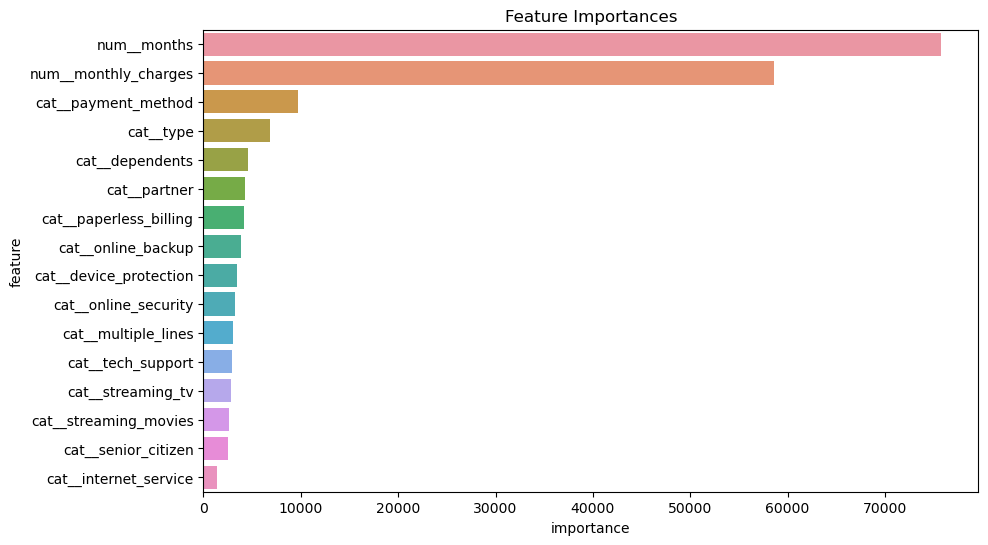

In [108]:
# Extract the feature importances and create a DataFrame
lgbm_step = best_lgbm.named_steps["lgbmclassifier"]
feature_importances = lgbm_step.feature_importances_
feature_names = best_lgbm[:-1].get_feature_names_out()
imp = pd.DataFrame(
    {"feature": feature_names, "importance": feature_importances}
).sort_values(by="importance", ascending=False)

# Barplot
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=imp, ax=ax)
plt.title("Feature Importances")
plt.show()

* The main contributors to the prediction results of the model are the features 'months' and 'monthly_charges'.

### ROC Curve

ROC AUC (Receiver Operating Characteristic Area Under the Curve) is a metric used to evaluate the performance of a binary classification model.

The ROC curve (Receiver Operating Characteristic Curve) represents the plot of the True Positive Rate (TPR) against the False Positive Rate (FPR) as the classification threshold changes.

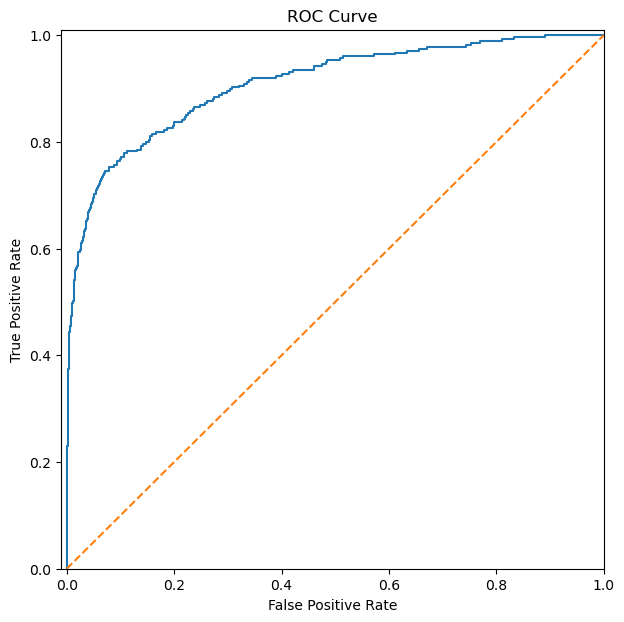

In [109]:
# Plotting the ROC curve
y_prob = best_lgbm.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr)
# ROC curve of a random model (appears as a straight line)
plt.plot([0, 1], [0, 1], linestyle="--")
# Set the axis limits from 0 to 1
plt.ylim([0.0, 1.01])
plt.xlim([-0.01, 1.0])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

plt.show()

### Сonfusion matrix

To assess how well a model predicts different classes (the target variable), we can construct a Confusion Matrix.

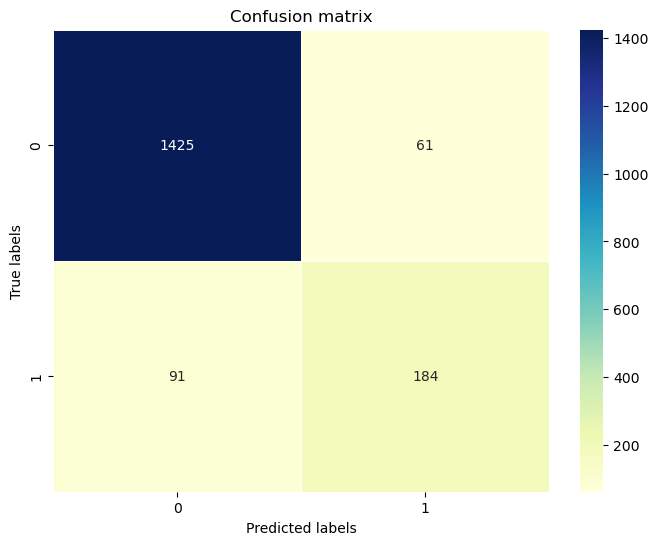

In [110]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.set_title("Confusion matrix")
sns.heatmap(cm, linewidth=0.5, ax=ax, annot=True, cmap="YlGnBu", fmt="d")

ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels");

The confusion matrix shows how well the selected model predicts different classes and the number of incorrect and correct predictions for each class.

* True Positive (TP): The number of correctly predicted churned customers (class 1). - **184**
* True Negative (TN): The number of correctly predicted non-churned customers (class 0). - **1425**
* False Positive (FP): The number of incorrectly predicted churned customers (class 0 predicted as class 1). - **61**
* False Negative (FN): The number of incorrectly predicted non-churned customers (class 1 predicted as class 0). - **91**

* Let's calculate the values of Recall (Sensitivity) and Precision for the selected model.

#### Recall

Recall, also known as sensitivity or true positive rate, measures the proportion of actual positive cases that are correctly identified as positive by a model. It is calculated as the ratio of true positives to the sum of true positives and false negatives. Recall provides information about the model's ability to find all positive instances in a dataset.

In [111]:
# Recall
recall = recall_score(y_test, y_pred)
print("Recall: {:.4f}".format(recall))

Recall: 0.6691


#### Precision

Precision measures the proportion of true positive predictions out of all positive predictions made by a model. It focuses on the accuracy of positive predictions rather than capturing all actual positive cases. Precision is calculated as the ratio of true positives to the sum of true positives and false positives. It provides insights into the model's ability to minimize false positive predictions.

In [112]:
# Посчитаем Precision
precision = precision_score(y_test, y_pred)
print("Precision: {:.4f}".format(precision))

Precision: 0.7510


#### Threshold

The threshold in the context of machine learning and classification tasks determines which predicted values will be classified as positive and which as negative, and it affects the values of the Precision and Recall metrics.

* By adjusting the threshold value, one can influence the values of these two metrics without affecting the values of the ROC-AUC and Accuracy metrics.
* Let's plot graphs showing the dependence of Precision and Recall on the Threshold value.

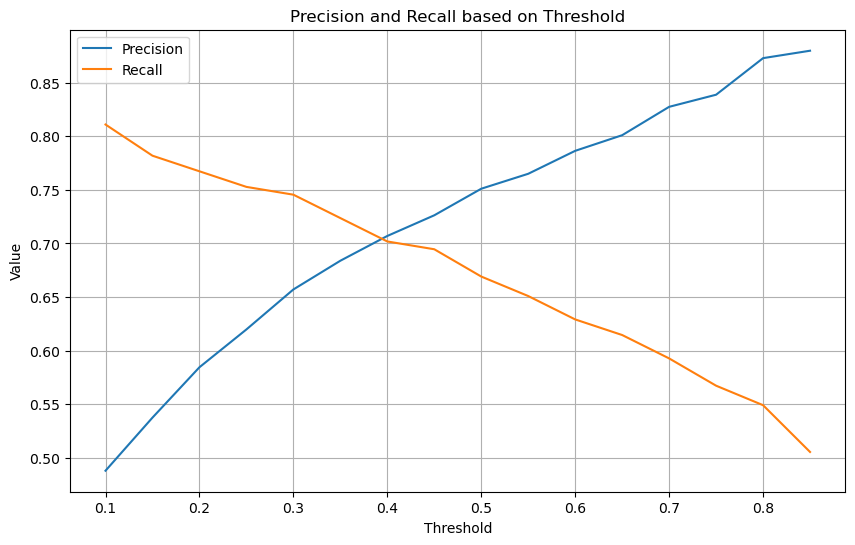

In [113]:
# Threshold
y_pred_prob = best_lgbm.predict_proba(X_test)[:, 1]

# Define thresholds
thresholds = np.arange(0.1, 0.9, 0.05)

# Initialize lists to store precision and recall values
precisions = []
recalls = []

# Calculate precision and recall for each threshold
for threshold in thresholds:
    y_pred_t = (y_pred_prob > threshold).astype(int)
    precision = precision_score(y_test, y_pred_t)
    recall = recall_score(y_test, y_pred_t)
    precisions.append(precision)
    recalls.append(recall)

# Plot precision and recall values
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Value")
plt.title("Precision and Recall based on Threshold")
plt.legend()
plt.grid(True)
plt.show()

From the above graph, it can be observed that the optimal threshold value is around 0.4 for this model. However, in a real-world scenario like ours, it is important to understand which of the two metrics is more important. This may depend on the cost of customer retention (marketing activities). If we aim to more accurately identify customers who may churn (True Positive), we increase the number of errors (False Negative) and thus spend marketing budgets on retaining customers who are not actually planning to leave the company.

* We can assume that in our case, the cost of customer retention is low and the revenues from an active customer outweigh the costs that our company may incur by investing in retaining customers who were not planning to leave. Therefore, we need to shift the threshold towards 0.1.

### Conclusions after testing

Conclusion after testing.

The LightGBM model that was selected earlier was tested on the test dataset.
* The model showed good results, achieving the target value of ROC AUC >= 0.85.
<br><br>
ROC AUC value: 0.908276
<br>
Accuracy value: 0.913685

Feature importance analysis was conducted, and a bar chart was plotted to show the influence of each feature on the machine learning model's results. The features that had the strongest impact on the predictions were:
* `paperless_billing` - paperless billing.
* `type` - payment type: monthly, yearly, etc.

At the standard classification threshold of 0.5, the model had the following metric values:
<br>
Recall: 0.6691
<br>
Precision: 0.7510
<br><br>
In the context of our task, we can assume that the costs of customer retention are not high, and the revenue from an active customer outweighs the costs that our company can incur by investing in retaining customers who were not intending to leave.

Based on this assumption, by adjusting the classification threshold, we can increase the proportion of correct predictions for customers who are leaving the company, while the prediction quality for the opposite class will decrease. By increasing the Recall value, the Precision value decreases.

To evaluate the changes in the metrics, the "Precision and Recall based on Threshold" line chart can be used (with a threshold value of 0.4).

To assess the number of true and false predictions for both classes, the "Dynamic Confusion Matrix" can be used (included in the project), which changes its values depending on the threshold value.

Depending on the specific business requirements and additional data, further fine-tuning of the existing model can be performed.


## Final conclusion of the project

### Abstract:
- A brief summary of the project, including the problem statement, approach, and key results.

_Development of customer churn prediction model._

In this project, our team developed a customer churn prediction model for a telecommunications operator. By using data obtained from applying such a model, it is possible to identify customers who may churn in advance and take measures to retain them. The cost of marketing expenses to regain a lost customer is quite high, so it is more cost-effective to retain the customer.

To achieve this goal, we utilized available data about customers, information about tariffs and contracts, and tackled the problem as a binary classification task. We developed and tested three classifier models, setting the target value of the ROC AUC metric to be >= 0.85. Based on the testing results, we will provide the client with a model that achieves this level of metric performance.

### Introduction:
   - Background information on the problem we worked on.
   - Objectives and research questions.

Predicting customer churn is a common task in the list of problems that can be addressed using machine learning models trained on labeled data (supervised learning).

To solve such a task, it is necessary to train a model to perform binary classification. By determining the probability of which class a customer belongs to based on available customer data and labeled data indicating whether the customer is active or has stopped using the company's services. The completeness, quality, and quantity of the source data are important factors for solving this problem.

Machine learning models such as logistic regression, random forest, or gradient boosting models can be successfully applied to train such a classifier based on available tabular data.

The main challenge in this project is to correctly select features that do not leak the target variable. In our case, these are features generated from combinations of `EndDate` and `BeginDate`. We addressed this issue by analyzing the correlation of these features. Additionally, in the case of high metric values on the validation set, we conducted an analysis of feature importance for the model.

The second most challenging task is to consider all the comments and guidelines from the team lead and make the necessary corrections within the given timeline. We managed to accomplish this with considerable effort, thanks to the collaborative work with our senior mentor, Evgeniy Arzamastsev.

The research questions we focused on include:
- Which factors have the greatest impact on customer churn?
- Which classification models allow for the most accurate prediction of churn?

### Dataset:
   - Description of the datasets used in our project.
   - Data collection process and preprocessing steps.
   - Statistical analysis and exploration of the data.

In our disposal, we have several datasets obtained from different sources:
- `contract_new.csv` - contract information
- `personal_new.csv` - customer personal data
- `internet_new.csv` - information about internet services
- `phone_new.csv` - information about phone services

The contract information is up to date as of February 1, 2020.

**Results of Data Exploratory Analysis**

* Sizes of the original datasets:
   * Size of the contract dataset: (7043, 8)
   * Size of the personal dataset: (7043, 5)
   * Size of the internet dataset: (5517, 8)
   * Size of the phone dataset: (6361, 2)
<br><br>
* Number of unique customers (objects): 7043
* The target feature (contract termination status) can be derived from the `EndDate` feature in the `contract_new.csv` dataset.
   * Class imbalance is observed. 16% of the customers belong to the positive class (contract termination).
<br><br>
* The majority of features in the original datasets are categorical.
* Quantitative features - `MonthlyCharges` and `TotalCharges` from the `contract_new.csv` dataset.
* In total, there are 18 features available for the objects.
* No duplicates were found in the original data.
* Missing values (empty rows) were detected in the `TotalCharges` feature.
* The `BeginDate` and `EndDate` features in the `contract_new.csv` dataset are of the object type, containing date information.
<br><br>
To facilitate further data processing, the original datasets were merged into one working dataset using the unique customer identification number `customerID` as the key for merging. During the merging process, missing values appeared in the features from the `df_internet` and `df_phone` tables, which was expected since these tables had fewer objects/customers compared to the `df_contract` and `df_personal` tables. It is worth noting that the `df_internet` and `df_phone` tables contain information about individual sets of "Internet" and "Phone" services, respectively. Therefore, not all customers could have subscribed to both services, and some chose only one of them.

**Data Preprocessing**

The following data preprocessing steps were performed:
- Renaming feature names from CamelCase to snake_case.
- Handling missing values:
   - `TotalCharges` feature - filled missing values with zero.
   - Missing values that occurred during the merging of tables were filled with the value 'No', indicating that the corresponding customer did not subscribe to that particular service.
- Changing data types for features:
   - `EndDate` and `BeginDate` were changed from object type to datetime64 (for active customers, `EndDate` was filled with February 1, 2020).
- Generating new features from `EndDate` and `BeginDate`: `year`, `month`, and `months` (year and month of the contract's conclusion and the duration of the contract in months).
- Generating a new feature `total_calc` from `MonthlyCharges` and `months`.
- Generating the target feature `target` (binary feature - 0 or 1) from the `EndDate` feature.
- Removing columns `CustomerID` (does not provide useful information in its values), `EndDate` (directly related to the target feature), and `BeginDate` (new features have been generated based on it).

**Multicollinearity Check**

Multicollinearity check was performed using the phik library, which provides tools for calculating the phi correlation coefficient, a measure of the relationship between variables. It can be used to analyze the relationships between categorical

 and numerical variables in a dataset.

A correlation coefficient matrix was constructed. Based on the analysis of the matrix, some features were removed:
- Strong correlation between `total_charges` and the generated feature `total_calc`. The generated feature duplicates the existing one and should be removed.
- The combination of the `total_charges` feature with the `year`/`months`/`month` features allows calculating customers who terminated their contracts. Therefore, the pair of features `year`/`months` needs to be removed.

The final dataset contains the following data:
- Number of unique customers (objects): 7043
- Features:
   - 'type', 'paperless_billing', 'payment_method', 'monthly_charges',
     'senior_citizen', 'partner', 'dependents', 'internet_service',
     'online_security', 'online_backup', 'device_protection', 'tech_support',
     'streaming_tv', 'streaming_movies', 'multiple_lines',
     'months'
- Target feature:
   - 'target'

### Methodology:
   - Description of machine learning techniques and algorithms used in the project.
   - Feature engineering and selection.
   - Model architecture and tuning parameters.
   - Evaluation metrics used.

**Key Steps in Problem Solving**:
- Preprocessing and analysis of the initial datasets
- Handling missing values after data merging
- Exploratory data analysis
- Feature generation
- Checking for multicollinearity (feature analysis)
- Feature selection
- Creating pipelines for transforming categorical and numerical features
- Splitting into training and testing sets
- Selection of models for training and validation
- Determining hyperparameters for the selected models
- Training with cross-validation and hyperparameter tuning
- Analysis of results (tuning)
- Selection of the best model and obtaining metrics on the test set
- Analysis of the obtained metrics
- Analysis of feature importance
- Determining additional metrics for better understanding of prediction results
- Creation and analysis of the Confusion Matrix
- Conclusion of the project

To solve the classification task in our project, the following classifiers were used:
- Logistic Regression (LogisticRegression()) from the sklearn library
- Random Forest (RandomForestClassifier())
- LightGBM Gradient Boosting Model (LGBMClassifier())

For each of the models, a pipeline of transformers was prepared to preprocess the data in the required format:
- For linear models, the values of categorical features needed to be encoded into numerical values, specifically 0 and 1. The `OneHotEncoder()` transformer was used for this type of models.
- For models with decision trees, the values of categorical features also needed to be encoded into numerical values. The `OrdinalEncoder()` transformer was used for this type of models.
- For gradient boosting models, it was not possible to fine-tune internal values for transforming categorical data. Therefore, the `OrdinalEncoder()` transformer, as used for the random forest model, was employed for this type of models as well.
- The `MinMaxScaler()` method was applied to numerical features for all model families.

The `make_pipeline` method from sklearn.pipeline and `ColumnTransformer` from sklearn.compose were used to create the pipeline.

The transformers were trained separately on the training set and then applied to both the training and testing sets.

To split the initial dataset into subsets (training/test), the `train_test_split` method from sklearn.model_selection was used. 
- The test set size was set to 25% of the original dataset size.
- A constant RANDOM_STATE = 20623 was used for reproducibility throughout the project.

The `GridSearchCV` method from sklearn.model_selection was employed for hyperparameter tuning and model training with cross-validation.

The chosen metric to evaluate the classification performance was ROC-AUC (Receiver Operating Characteristic Area Under the Curve).

### Experimental Results:
- Presentation of the results, including performance metrics and tables.
- Discussion and analysis of the results.
- Comparison with baseline models or previous works, if applicable.

**Hyperparameters and Performance Metrics of the Best Models.**

* Dummy Model
   - ROC-AUC of the Dummy model: 0.5000

* Logistic Regression
   - ROC-AUC: 0.7539
   - Hyperparameters:
     - logisticregression__C: 2
     - logisticregression__class_weight: 'balanced'
     - logisticregression__penalty: 'l1'
     - logisticregression__solver: 'liblinear'

* Random Forest Classifier
   - ROC-AUC: 0.8310
   - Hyperparameters:
     - randomforestclassifier__class_weight: 'balanced'
     - randomforestclassifier__criterion: 'entropy'
     - randomforestclassifier__max_depth: 10
     - randomforestclassifier__max_samples: 0.5
     - randomforestclassifier__min_samples_leaf: 2
     - randomforestclassifier__n_estimators: 4000

* **LightGBM Classifier**
   - ROC-AUC: **0.8951**
   - Hyperparameters:
     - lgbmclassifier__class_weight: 'balanced'
     - lgbmclassifier__learning_rate: 0.01
     - lgbmclassifier__n_estimators: 10000
     - lgbmclassifier__num_leaves: 20

The best performance in terms of the metric was achieved by the `LightGBM Classifier` with an ROC-AUC of 0.8951. The metrics for this model will be determined using the test dataset.

_You can find a summary table with the results of all hyperparameter variations and key metrics in the Appendix._

### Discussion:
   - Interpretation of results and their significance.
   - Possible directions for improvement and further research.

We determined that the best ROC-AUC values for the training set were obtained with the LightGBM Classifier model.

- We obtained predictions from this model on the test set and calculated the ROC-AUC and Accuracy metrics.
    * ROC-AUC: 0.9082760308332315
    * Accuracy: 0.9136854060193073
<br><br>

- The target ROC-AUC value of above 0.85 has been achieved.

Additionally, a feature importance analysis was conducted. The main contributors to the model's prediction results were the features "months" and "monthly_charges."Additionally, a Confusion Matrix was constructed for the LGBMClassifier model with results on the test set using a classification threshold of 0.5.

The Confusion Matrix shows how the selected model predicts different classes and the number of correct and incorrect predictions for each class.

- True Positive (TP): The number of correctly predicted churned customers (class 1) - **184**
- True Negative (TN): The number of correctly predicted retained customers (class 0) - **1425**
- False Positive (FP): The number of incorrectly predicted churned customers (class 0 predicted as class 1) - **61**
- False Negative (FN): The number of incorrectly predicted retained customers (class 1 predicted as class 0) - **91**

_A dynamic Confusion Matrix for the LGBMClassifier model can be found in the Appendix._

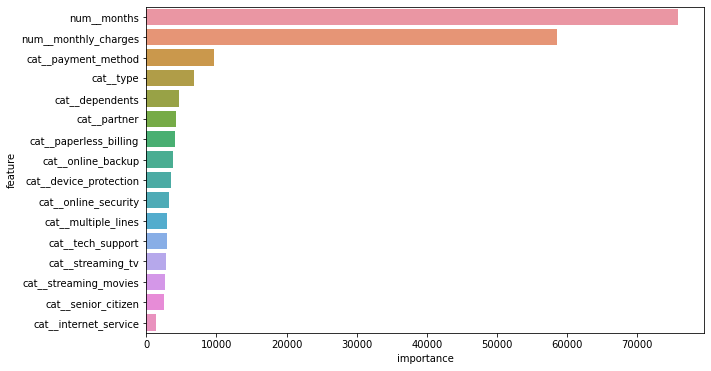

Additionally, a Confusion Matrix was constructed for the LGBMClassifier model with results on the test set using a classification threshold of 0.5.

The Confusion Matrix shows how the selected model predicts different classes and the number of correct and incorrect predictions for each class.

- True Positive (TP): The number of correctly predicted churned customers (class 1) - **184**
- True Negative (TN): The number of correctly predicted retained customers (class 0) - **1425**
- False Positive (FP): The number of incorrectly predicted churned customers (class 0 predicted as class 1) - **61**
- False Negative (FN): The number of incorrectly predicted retained customers (class 1 predicted as class 0) - **91**

_A dynamic Confusion Matrix for the LGBMClassifier model can be found in the Appendix._

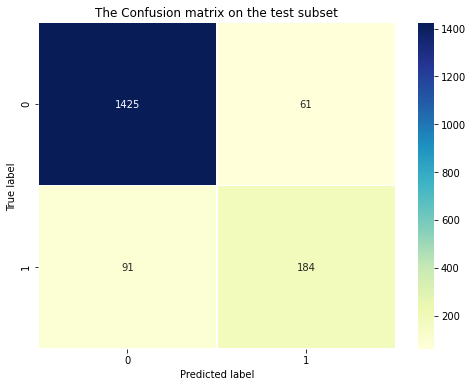

Additionally, the values of Recall and Precision were calculated for a classification threshold of 0.5:
- Recall: 0.6691
- Precision: 0.7510

By adjusting the classification threshold value, the Recall and Precision values can be modified based on business requirements.
**The results of the developed model meet the business requirements, and this model can be used for customer churn prediction.**

- Possible directions for improvement and further research:
    * The performance of the model can potentially be improved by generating additional features. For example, conducting clustering based on the original data and using cluster values as an additional feature.
    * The model can also be enhanced by optimizing hyperparameters to improve training and prediction times.
  
  
- Overall, the execution of this project went as initially planned. In the initial version, the combination of features `month` and `months`, which leak into the target feature `target`, was overlooked. The issue was resolved by removing the `month` feature. The final solution incorporates this fix and eliminates the error.

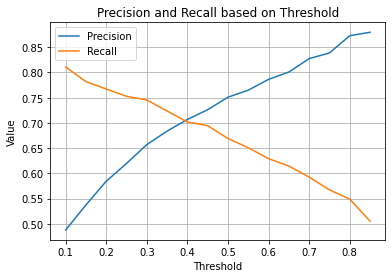

**The results of the developed model meet the business requirements, and this model can be used for customer churn prediction.**

- Possible directions for improvement and further research:
    * The performance of the model can potentially be improved by generating additional features. For example, conducting clustering based on the original data and using cluster values as an additional feature.
    * The model can also be enhanced by optimizing hyperparameters to improve training and prediction times.
  
  
- Overall, the execution of this project went as initially planned. In the initial version, the combination of features `month` and `months`, which leak into the target feature `target`, was overlooked. The issue was resolved by removing the `month` feature. The final solution incorporates this fix and eliminates the error.

### List of resources:
   - List of cited sources and resources.


1. Checking for multicollinearity (Phik): [https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7)
2. Pipeline and ColumnTransformer: [https://towardsdatascience.com/pipelines-custom-transformers-in-scikit-learn-the-step-by-step-guide-with-python-code-4a7d9b068156](https://towardsdatascience.com/pipelines-custom-transformers-in-scikit-learn-the-step-by-step-guide-with-python-code-4a7d9b068156)
3. Pipeline and GridSearch: [https://towardsdatascience.com/an-introduction-to-building-pipelines-and-using-grid-searches-in-scikit-learn-92ea72f9b5b7](https://towardsdatascience.com/an-introduction-to-building-pipelines-and-using-grid-searches-in-scikit-learn-92ea72f9b5b7)
4. Customer Churn Prediction Model Development for a Bank: [https://github.com/ivansakov/public/tree/f37c12ecd03074d943ed9cbc8fa43a7e88f0cfed](https://github.com/ivansakov/public/tree/f37c12ecd03074d943ed9cbc8fa43a7e88f0cfed)

### Appendix:
  - Additional details, code snippets, or supplementary information.

**Dynamic Confusion Matrix**

* Below is a dashboard that shows how predictions change when the threshold value is adjusted.
* The threshold value can and should be changed.

In [114]:
import ipywidgets as widgets
from IPython.display import display


def update_plot(new_threshold):
    # Apply the new threshold
    y_pred = (y_pred_prob > new_threshold).astype(int)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Clear previous plot
    plt.clf()

    # Plot the confusion matrix
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.set_title("The Сonfusion matrix on the test subset")
    sns.heatmap(cm, linewidth=0.5, ax=ax, annot=True, cmap="YlGnBu", fmt="d")

    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    plt.show()


# Get the predicted probabilities for the positive class
y_pred_prob = best_lgbm.predict_proba(X_test)[:, 1]

# Create a slider widget for the threshold
threshold_slider = widgets.FloatSlider(
    value=0.5, min=0.1, max=0.9, step=0.05, description="Threshold"
)

# Create an interactive output for the plot
output = widgets.interactive_output(update_plot, {"new_threshold": threshold_slider})

# Display the slider and the plot
display(threshold_slider, output)

FloatSlider(value=0.5, description='Threshold', max=0.9, min=0.1, step=0.05)

Output()